# Diagnosis of Chagas Disease using PTB-XL Dataset

### Environment Setup

* In this notebook, we'll be analyzing ECG data from the PhysioNet PTB-XL dataset to identify patterns associated with Chagas disease. 

* First, we need to install the required libraries. The WFDB (WaveForm DataBase) package will be used to handle and process ECG signal data.

In [1]:
# Installing the WFDB (WaveForm DataBase) package for reading and processing ECG signals
# The -q flag keeps the installation output quiet/minimal
!pip install wfdb -q

In [2]:
import pandas as pd
import numpy as np
import wfdb

# Importing ast (Abstract Syntax Trees) module
# This allows us to work with Python code represented as abstract syntax trees
# We'll use this to safely evaluate string representations of Python data structures

import ast

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Data Loading Functions

* The PTB-XL dataset contains ECG recordings at two different sampling rates: 100 Hz (low resolution) and 500 Hz (high resolution). The following function allows us to load the raw ECG signals based on the specified sampling rate.

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

### Dataset Configuration

* The PTB-XL dataset is a large, publicly available electrocardiography dataset that contains 21,837 clinical 12-lead ECG records from 18,885 patients. Here we specify the path to the dataset on the local machine and set our desired sampling rate for analysis.

In [5]:
path = 'C:\\Users\\rjhha\\Downloads\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\'
sampling_rate=100

### Load Dataset Metadata

* The PTB-XL dataset comes with a comprehensive CSV file "ptbxl_database.csv" that contains metadata for each ECG recording. This includes patient demographics, diagnostic information, and file locations. We'll load this metadata to organize and navigate through the available ECG signals usning the index col "ecg_id".

In [6]:
# Load the metadata CSV file into a pandas DataFrame
# Use 'ecg_id' as the index column for easier lookup

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')

# The SCP codes column contains diagnostic information stored as string representations of Python dictionaries
# Convert the string representations to actual dictionaries using ast.literal_eval
# This allows us to access individual diagnostic codes and their corresponding confidence scores
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

### Data Cleaning Functions

* Some ECG recordings in the PTB-XL dataset are labeled as normal ("NORM"). For our Chagas disease analysis, we need to clean the diagnostic codes by filtering out the normal cases, leaving only the relevant pathological conditions.

In [7]:
def clean(dicts):

    """
    Clean the diagnostic codes dictionary by removing 'NORM' (normal) labels.
    
    Parameters:
    -----------
    dicts : dict
        Dictionary containing SCP diagnostic codes as keys and confidence scores as values
        
    Returns:
    --------
    dict
        Cleaned dictionary without the 'NORM' code
    """
    final = {}
    for k,v in dicts.items():
        if k == "NORM":
            continue
        else:
            final[k] = v
    return final

### Clean Diagnostic Labels

* Now that we've defined our cleaning function, we'll apply it to all ECG records in the dataset. This step removes the "NORM" (normal) label from the diagnostic codes, allowing us to focus on the pathological findings that may indicate Chagas disease or other cardiac conditions.

In [8]:
Y["scp_codes"] = Y.scp_codes.apply(lambda x: clean(x))


### Loading the ECG Signal Data

* After preparing the metadata and cleaning the diagnostic labels, we'll now load the actual ECG signal data. Here we'll use our previously defined `load_raw_data` function to load the raw ECG signals.

In [9]:
X = load_raw_data(Y, sampling_rate, path)  

### Loading and Filtering Diagnostic Statements

The PTB-XL dataset includes a list of SCP diagnostic statements that map to the codes in our dataset. We'll load this mapping and filter it to include only diagnostic statements (excluding non-diagnostic descriptions like technical quality or rhythm assessments).

In [10]:
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

# Filter the dataframe to keep only rows where the 'diagnostic' column equals 1
agg_df = agg_df[agg_df.diagnostic == 1]

### Aggregate Diagnostic Classifications

* The PTB-XL dataset uses fine-grained SCP diagnostic codes, but we want to work with broader diagnostic categories. This function aggregates the detailed diagnostic codes into their parent diagnostic classes, which will help us focus on identifying patterns related to Chagas disease.

In [11]:
def aggregate_diagnostic(y_dic):
    """
    Aggregate detailed SCP diagnostic codes into broader diagnostic classes.
    
    Parameters:
    -----------
    y_dic : dict
        Dictionary containing SCP diagnostic codes as keys and confidence scores as values
        
    Returns:
    --------
    list
        List of unique diagnostic classes corresponding to the input diagnostic codes
    """

    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return [x for x in set(tmp)]

### Creating Diagnostic Superclass Feature

* Now that we have our aggregation function ready, we'll apply it to each record in our dataset. This will create a new column in our metadata DataFrame that contains the broader diagnostic categories for each ECG recording, which will be useful for identifying patterns related to Chagas disease.

In [12]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

### Extract Unique Diagnostic Classes

* To understand the distribution of different cardiac conditions in our dataset, we'll count the occurrences of each diagnostic superclass. This will help us identify how many potential Chagas disease cases we have in the dataset, as well as other cardiac conditions that might share similar ECG patterns.

In [13]:
diagnosis = Y.diagnostic_superclass.value_counts().index

### Create Chagas Disease-Related Labels

* Chagas disease (American trypanosomiasis) often manifests with specific ECG patterns. The most characteristic finding is the combination of right bundle branch block (RBBB) and left anterior fascicular block (LAFB). Other common findings include atrioventricular blocks, premature ventricular contractions, ST-T wave changes, and Q waves.

* This function creates binary labels for each of these Chagas-related findings, allowing us to identify potential Chagas cases in the PTB-XL dataset.



## Literature Sources:

* [1] A. Rassi Jr, A. Rassi, and J. A. Marin-Neto, "Chagas disease," Lancet, vol. 375, no. 9723, pp. 1388-1402, 2010.
* * This review article describes the classic ECG findings in Chagas disease, including RBBB (often associated with LAFB), various degrees of AV block, and ventricular arrhythmias.
* [2] L. Z. Rojas et al., "Electrocardiographic abnormalities in Chagas disease in the general population: A systematic review and meta-analysis," PLoS Negl Trop Dis, vol. 12, no. 6, p. e0006567, 2018.
* * This systematic review confirms that RBBB (especially when combined with LAFB), AV blocks, and ventricular arrhythmias are the most common ECG findings in Chagas disease.
* [3] A. L. Ribeiro, M. P. Nunes, M. M. Teixeira, and M. O. Rocha, "Diagnosis and management of Chagas disease and cardiomyopathy," Nat Rev Cardiol, vol. 9, no. 10, pp. 576-589, 2012.
* * This review discusses how the combination of RBBB and LAFB is highly suggestive of Chagas disease in endemic areas.
* [4] M. C. P. Nunes et al., "Chagas Cardiomyopathy: An Update of Current Clinical Knowledge and Management," Circulation, vol. 138, no. 12, pp. e169-e209, 2018.
* * This American Heart Association scientific statement confirms that RBBB and LAFB are the most common conduction abnormalities, followed by AV blocks, PVCs, and other ventricular arrhythmias.
* [5] M. V. Elizari and P. A. Chiale, "Cardiac arrhythmias in Chagas' heart disease," J Cardiovasc Electrophysiol, vol. 4, no. 5, pp. 596-608, 1993.
* * This classic paper describes the various arrhythmias and conduction defects seen in Chagas cardiomyopathy, including RBBB, LAFB, and AV blocks.
* [6] A. Garcia-Alvarez et al., "Myocardial deformation analysis in Chagas heart disease with the use of speckle tracking echocardiography," J Card Fail, vol. 17, no. 12, pp. 1028-1034, 2011.
* * This paper describes both the classic ECG findings and newer imaging findings in Chagas cardiomyopathy.
* [7] M. V. L. Barros, F. S. Machado, A. L. P. Ribeiro, and M. O. Da Costa Rocha, "Detection of early right ventricular dysfunction in Chagas' disease using Doppler tissue imaging," J Am Soc Echocardiogr, vol. 15, no. 10, pp. 1197-1201, 2002.
* * This study shows the correlation between ECG abnormalities (particularly RBBB and LAFB) and right ventricular dysfunction in Chagas patients.
* [8] J. A. Marin-Neto, E. Cunha-Neto, B. C. Maciel, and M. V. Simões, "Pathogenesis of chronic Chagas heart disease," Circulation, vol. 115, no. 9, pp. 1109-1123, 2007.
* * This paper discusses the mechanisms behind the ECG abnormalities, particularly focusing on how the parasite-triggered inflammation leads to conduction system damage.

#### These sources confirm that the ECG abnormalities you're targeting—particularly the combination of RBBB and LAFB, along with AV blocks, PVCs, ST-T changes, and Q waves—are indeed highly associated with Chagas disease cardiomyopathy.

In [14]:
def create_chagas_related_labels(Y, scp_statements_df):
    # Initialize a DataFrame for our binary labels
    chagas_labels = pd.DataFrame(index=Y.index)
    
    # Map our conditions to actual SCP codes from the dataset
    # Using the correct codes as they appear in the PTB-XL dataset
    chagas_related = {
        'RBBB': ['IRBBB', 'CRBBB'],  # Both incomplete and complete right bundle branch block
        'LAFB': ['LAFB'],            # Left anterior fascicular block
        'AVB': ['1AVB', '2AVB', '3AVB'],  # First, second and third degree AV blocks
        'PVC': ['PVC'],              # Premature ventricular contractions
        'STT': ['STD', 'STE', 'NDT'],  # ST-T wave changes
        'Q_WAVE': ['IMI', 'AMI', 'LMI']  # Q waves (often seen in infarctions)
    }
    
    # Create a binary column for each condition
    for condition, codes in chagas_related.items():
        chagas_labels[condition] = Y.scp_codes.apply(
            lambda x: 1 if any(code in x for code in codes) else 0)
    
    # Create a "Chagas Pattern" column for cases with both RBBB and LAFB
    chagas_labels['CHAGAS_PATTERN'] = ((chagas_labels['RBBB'] == 1) & 
                                      (chagas_labels['LAFB'] == 1)).astype(int)
    
    return chagas_labels

In [15]:
# Create labels for Chagas-related conditions
chagas_labels = create_chagas_related_labels(Y, agg_df)

In [16]:
# Display label distribution
print("Distribution of Chagas-related ECG conditions:")
for col in chagas_labels.columns:
    count = chagas_labels[col].sum()
    percentage = (count / len(chagas_labels)) * 100
    print(f"{col}: {count} cases ({percentage:.2f}%)")

Distribution of Chagas-related ECG conditions:
RBBB: 1659 cases (7.60%)
LAFB: 1626 cases (7.45%)
AVB: 827 cases (3.79%)
PVC: 1146 cases (5.25%)
STT: 1829 cases (8.38%)
Q_WAVE: 3137 cases (14.37%)
CHAGAS_PATTERN: 284 cases (1.30%)


### Data Preparation for Model Training

* Before training our machine learning models to detect Chagas disease patterns in ECG signals, we need to properly prepare and preprocess our data. The function below handles data splitting, reshaping, and standardization to ensure optimal model performance.

* This preprocessing pipeline is crucial for ECG data analysis since the signals need to be properly normalized while preserving their temporal characteristics.

In [17]:
# Prepare data for model training
def prepare_data(X, labels, test_size=0.2, val_size=0.2):
    """
    Prepare ECG data for model training by splitting into train/validation/test sets,
    reshaping for model input, and standardizing features.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Array of ECG signals with shape (n_samples, n_timesteps, n_features)
    labels : pandas.DataFrame or numpy.ndarray
        Binary labels for the target conditions (e.g., Chagas-related ECG patterns)
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split
    val_size : float, default=0.2
        Proportion of the dataset to include in the validation split
    
    Returns:
    --------
    tuple
        (X_train, X_val, X_test, y_train, y_val, y_test) - Preprocessed data splits
    """
    # Split into training and temporary sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, labels, test_size=(test_size + val_size), random_state=42)
    
    # Split temporary set into validation and test sets
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_ratio), random_state=42)
    
    # Reshape data for CNN input
    n_samples, n_timesteps, n_features = X.shape
    X_train = X_train.reshape(X_train.shape[0], n_timesteps * n_features)
    X_val = X_val.reshape(X_val.shape[0], n_timesteps * n_features)
    X_test = X_test.reshape(X_test.shape[0], n_timesteps * n_features)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Reshape back for CNN
    X_train = X_train.reshape(-1, n_timesteps, n_features)
    X_val = X_val.reshape(-1, n_timesteps, n_features)
    X_test = X_test.reshape(-1, n_timesteps, n_features)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Target Selection for Chagas Disease Detection

* Now we'll focus specifically on detecting the most characteristic ECG pattern of Chagas disease: the combination of Right Bundle Branch Block (RBBB) and Left Anterior Fascicular Block (LAFB). This pattern is highly suggestive of Chagas cardiomyopathy in endemic areas and provides a strong biomarker for our detection algorithm.

* After selecting our target variable, we'll prepare our dataset using the previously defined function to split, reshape, and standardize our ECG data.

In [18]:
# Let's focus on predicting CHAGAS_PATTERN (RBBB + LAFB)
target_col = 'CHAGAS_PATTERN'
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    X, chagas_labels[target_col])


## CNN Model Architecture for Chagas Pattern Recognition

This deep learning model utilizes a 1D Convolutional Neural Network specifically optimized for ECG signal analysis to detect the characteristic RBBB+LAFB pattern associated with Chagas disease cardiomyopathy.

## Architecture Details

### Convolutional Feature Extraction Layers

The model employs three sequential convolutional blocks, each increasing in complexity:

1. **First Convolutional Block**
   - 64 filters with kernel size 5 to capture basic ECG morphological features
   - ReLU activation function to introduce non-linearity
   - Batch normalization to stabilize training and accelerate convergence
   - Max pooling with pool size 2 to reduce dimensionality by 50%

2. **Second Convolutional Block**
   - Increased filter count to 128 to detect more complex patterns
   - Maintained kernel size 5 for consistent feature window
   - Identical BatchNormalization and MaxPooling configuration for consistency
   - Further reduces temporal dimension by 50%

3. **Third Convolutional Block**
   - 256 filters for high-level feature abstraction
   - Maintains kernel size 5 for final convolutional processing
   - Final max pooling further reduces representation size

### Feature Processing Layers

After feature extraction:
- **Flatten layer**: Transforms the multi-dimensional feature maps into a 1D feature vector

### Classification Layers

Two dense layers with dropout for regularization:
1. **First Dense Layer**
   - 128 neurons for complex pattern recognition
   - ReLU activation
   - Heavy dropout (50%) to prevent overfitting to training data

2. **Second Dense Layer**
   - 64 neurons for refined feature processing
   - ReLU activation
   - Moderate dropout (30%) for continued regularization

3. **Output Layer**
   - Single neuron with sigmoid activation
   - Outputs probability (0-1) of Chagas disease pattern presence

### Model Configuration

- **Optimizer**: Adam optimizer with default learning rate
- **Loss Function**: Binary cross-entropy (standard for binary classification)
- **Evaluation Metrics**: 
  - Accuracy: Proportion of correctly classified examples
  - Area Under ROC Curve (AUC): Measures discrimination ability across classification thresholds

In [19]:
# Build CNN model for ECG classification
def build_cnn_model(input_shape):
    model = Sequential([
        # First convolutional layer
        Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Second convolutional layer
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Third convolutional layer
        Conv1D(filters=256, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Flatten layer
        Flatten(),
        
        # Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    # Compile model
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

In [20]:
# Create and train the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_cnn_model(input_shape)


c:\Users\rjhha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_chagas_model.h5', monitor='val_auc', 
                                  mode='max', save_best_only=True)

In [22]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9734 - auc: 0.6927 - loss: 0.2187

410/410 ━━━━━━━━━━━━━━━━━━━━ 108s 254ms/step - accuracy: 0.9735 - auc: 0.6928 - loss: 0.2186 - val_accuracy: 0.9858 - val_auc: 0.8648 - val_loss: 0.0731
Epoch 2/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9792 - auc: 0.8300 - loss: 0.1055

410/410 ━━━━━━━━━━━━━━━━━━━━ 103s 252ms/step - accuracy: 0.9792 - auc: 0.8301 - loss: 0.1054 - val_accuracy: 0.9881 - val_auc: 0.9441 - val_loss: 0.0465
Epoch 3/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9855 - auc: 0.9306 - loss: 0.0478

410/410 ━━━━━━━━━━━━━━━━━━━━ 105s 255ms/step - accuracy: 0.9855 - auc: 0.9306 - loss: 0.0478 - val_accuracy: 0.9879 - val_auc: 0.9539 - val_loss: 0.0588
Epoch 4/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 113s 277ms/step - accuracy: 0.9869 - auc: 0.9405 - loss: 0.0397 - val_accuracy: 0.9883 - val_auc: 0.9371 - val_loss: 0.0547
Epoch 5/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 150s 295ms/step - accuracy: 0.9860 - auc: 0.9231 - loss: 0.0427 - val_accuracy: 0.9902 - val_auc: 0.9315 - val_loss: 0.0718
Epoch 6/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9900 - auc: 0.9258 - loss: 0.0391

410/410 ━━━━━━━━━━━━━━━━━━━━ 131s 320ms/step - accuracy: 0.9900 - auc: 0.9259 - loss: 0.0391 - val_accuracy: 0.9881 - val_auc: 0.9573 - val_loss: 0.0444
Epoch 7/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 140s 342ms/step - accuracy: 0.9905 - auc: 0.9714 - loss: 0.0272 - val_accuracy: 0.9892 - val_auc: 0.9482 - val_loss: 0.0497
Epoch 8/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 139s 338ms/step - accuracy: 0.9897 - auc: 0.9915 - loss: 0.0228 - val_accuracy: 0.9888 - val_auc: 0.9301 - val_loss: 0.0628
Epoch 9/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 136s 330ms/step - accuracy: 0.9891 - auc: 0.9798 - loss: 0.0270 - val_accuracy: 0.9915 - val_auc: 0.9508 - val_loss: 0.0415
Epoch 10/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 130s 316ms/step - accuracy: 0.9917 - auc: 0.9921 - loss: 0.0200 - val_accuracy: 0.9908 - val_auc: 0.9503 - val_loss: 0.0422
Epoch 11/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 120s 293ms/step - accuracy: 0.9925 - auc: 0.9674 - loss: 0.0208 - val_accuracy: 0.9908 - val_auc: 0.9548 - val_loss: 0.0433
Epoch 12/30
410/410 ━━━━━

In [23]:
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


In [24]:
# Print evaluation metrics
print("\nModel Evaluation for Chagas Pattern Detection:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")


Model Evaluation for Chagas Pattern Detection:
Confusion Matrix:
[[4310    8]
 [  36   14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4318
           1       0.64      0.28      0.39        50

    accuracy                           0.99      4368
   macro avg       0.81      0.64      0.69      4368
weighted avg       0.99      0.99      0.99      4368

ROC AUC Score: 0.9904


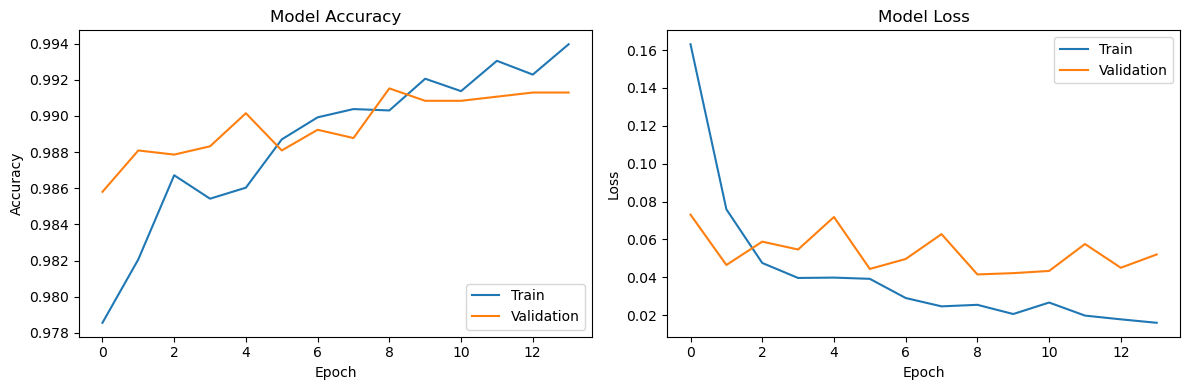

In [26]:

# Plot training history
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

## Multi-Label CNN for Comprehensive Chagas ECG Analysis

* While the previous model focused solely on detecting the RBBB+LAFB pattern, Chagas disease cardiomyopathy can manifest with multiple ECG abnormalities. This more advanced model enables simultaneous detection of all Chagas-related ECG patterns (RBBB, LAFB, AVB, PVC, ST-T changes, and Q-waves) using a multi-label classification approach.

By training a model to recognize all these patterns simultaneously, we can:
1. Identify patients with partial Chagas ECG manifestations
2. Quantify the extent of cardiac involvement
3. Better stratify risk based on the combination of abnormalities present

In [27]:
# Create a multi-label model for all Chagas-related conditions
def build_multi_label_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional layer
        Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Second convolutional layer
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Third convolutional layer
        Conv1D(filters=256, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Flatten layer
        Flatten(),
        
        # Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Output layer - multiple sigmoid outputs for multi-label classification
        Dense(num_classes, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

In [40]:
# Build a multi-label model to predict multiple Chagas-related ECG patterns
def build_multi_label_model(input_shape, num_classes):
    """
    Build a CNN model for multi-label classification of ECG signals.
    
    Parameters:
    -----------
    input_shape : tuple
        Shape of input data (timesteps, features)
    num_classes : int
        Number of output classes
        
    Returns:
    --------
    model : tensorflow.keras.Model
        Compiled multi-label classification model
    """
    model = Sequential([
        # First convolutional layer
        Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Second convolutional layer
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Third convolutional layer
        Conv1D(filters=256, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Flatten layer
        Flatten(),
        
        # Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Output layer - multiple sigmoid outputs for multi-label classification
        Dense(num_classes, activation='sigmoid')
    ])
    
    # Compile model - binary crossentropy for each output
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.AUC(name='auc'), 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# Train a multi-label model for all Chagas-related conditions
def train_multi_label_model(X, chagas_labels, test_size=0.2, val_size=0.2):
    """
    Train a multi-label model to predict all Chagas-related ECG patterns simultaneously.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Array of ECG signals
    chagas_labels : pandas.DataFrame
        DataFrame with binary labels for each Chagas-related condition
    test_size : float
        Proportion of dataset to use for testing
    val_size : float
        Proportion of dataset to use for validation
        
    Returns:
    --------
    multi_model : tensorflow.keras.Model
        Trained multi-label model
    label_cols : list
        List of column names for the target conditions
    y_pred_ml : numpy.ndarray
        Predicted probabilities for each condition
    y_pred_ml_binary : numpy.ndarray
        Binary predictions (0/1) for each condition
    """
    # Prepare multi-label data
    # Exclude CHAGAS_PATTERN which is a derived feature
    label_cols = [col for col in chagas_labels.columns if col != 'CHAGAS_PATTERN']
    
    # Split data
    X_train_ml, X_temp, y_train_ml, y_temp = train_test_split(
        X, chagas_labels[label_cols].values, test_size=(test_size + val_size), random_state=42)
    
    # Split temporary set into validation and test sets
    val_ratio = val_size / (test_size + val_size)
    X_val_ml, X_test_ml, y_val_ml, y_test_ml = train_test_split(
        X_temp, y_temp, test_size=(1 - val_ratio), random_state=42)
    
    # Reshape and standardize data
    n_samples, n_timesteps, n_features = X.shape
    
    # Reshape to 2D for scaling
    X_train_flat = X_train_ml.reshape(X_train_ml.shape[0], n_timesteps * n_features)
    X_val_flat = X_val_ml.reshape(X_val_ml.shape[0], n_timesteps * n_features)
    X_test_flat = X_test_ml.reshape(X_test_ml.shape[0], n_timesteps * n_features)
    
    # Standardize
    scaler = StandardScaler()
    X_train_flat = scaler.fit_transform(X_train_flat)
    X_val_flat = scaler.transform(X_val_flat)
    X_test_flat = scaler.transform(X_test_flat)
    
    # Reshape back to 3D for CNN
    X_train_ml = X_train_flat.reshape(-1, n_timesteps, n_features)
    X_val_ml = X_val_flat.reshape(-1, n_timesteps, n_features)
    X_test_ml = X_test_flat.reshape(-1, n_timesteps, n_features)
    
    # Define input shape for the model
    input_shape = (n_timesteps, n_features)
    
    # Build model
    print(f"Building multi-label model with {len(label_cols)} outputs: {label_cols}")
    multi_model = build_multi_label_model(input_shape, len(label_cols))
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc_5',  
        patience=10,
        mode='max',
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_multi_chagas_model.h5',
        monitor='val_auc_5',  
        mode='max', 
        save_best_only=True
    )
    
    # Train model
    print("Training multi-label model...")
    history = multi_model.fit(
        X_train_ml, y_train_ml,
        epochs=5,
        batch_size=32,
        validation_data=(X_val_ml, y_val_ml),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    # Evaluate
    print("Evaluating multi-label model...")
    y_pred_ml = multi_model.predict(X_test_ml)
    y_pred_ml_binary = (y_pred_ml > 0.5).astype(int)
    
    # Print per-class results
    for i, col in enumerate(label_cols):
        print(f"\nResults for {col}:")
        cm = confusion_matrix(y_test_ml[:, i], y_pred_ml_binary[:, i])
        print("Confusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(classification_report(y_test_ml[:, i], y_pred_ml_binary[:, i]))
        
        # Calculate and print AUC
        auc = roc_auc_score(y_test_ml[:, i], y_pred_ml[:, i])
        print(f"AUC: {auc:.4f}")
    
    # Visualize training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Return the model and predictions
    return multi_model, label_cols, y_pred_ml, y_pred_ml_binary, history




Building multi-label model with 6 outputs: ['RBBB', 'LAFB', 'AVB', 'PVC', 'STT', 'Q_WAVE']


c:\Users\rjhha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training multi-label model...
Epoch 1/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 123s 283ms/step - accuracy: 0.1430 - auc: 0.6090 - loss: 0.4797 - precision: 0.1091 - recall: 0.0954 - val_accuracy: 0.1124 - val_auc: 0.7252 - val_loss: 0.2661 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5


c:\Users\rjhha\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc_5` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)
c:\Users\rjhha\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_auc_5 available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


410/410 ━━━━━━━━━━━━━━━━━━━━ 107s 262ms/step - accuracy: 0.1602 - auc: 0.6869 - loss: 0.2926 - precision: 0.1400 - recall: 0.0067 - val_accuracy: 0.1305 - val_auc: 0.7650 - val_loss: 0.2486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 113s 274ms/step - accuracy: 0.1420 - auc: 0.7296 - loss: 0.2561 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1486 - val_auc: 0.7854 - val_loss: 0.2404 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 113s 276ms/step - accuracy: 0.1502 - auc: 0.7483 - loss: 0.2488 - precision: 0.0530 - recall: 1.3298e-04 - val_accuracy: 0.1282 - val_auc: 0.7873 - val_loss: 0.2364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 113s 275ms/step - accuracy: 0.1740 - auc: 0.7653 - loss: 0.2403 - precision: 0.0510 - recall: 1.1514e-04 - val_accuracy: 0.1601 - val_auc: 0.8115 - val_loss: 0.2313 - val_precision: 0.0000e+00 - val_r

c:\Users\rjhha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rjhha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rjhha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rjhha\anaconda3\Lib\site-packag

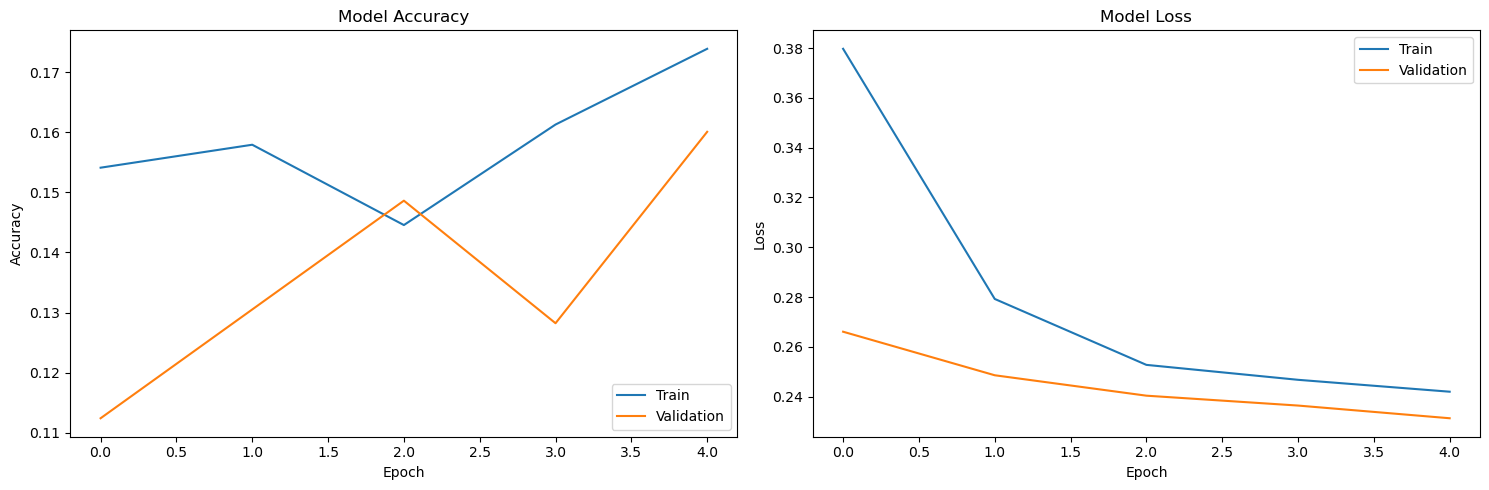

In [41]:
multi_model, label_cols, y_pred_ml, y_pred_ml_binary, history = train_multi_label_model(X, chagas_labels)

In [42]:
# Function to identify potential Chagas cases from the dataset
def identify_potential_chagas_cases():
    # Create a score based on number of Chagas-related patterns
    chagas_score = chagas_labels.sum(axis=1)
    
    # Get the top 20 cases with the most Chagas-related patterns
    potential_cases = chagas_score.sort_values(ascending=False)[:20]
    
    print("Top 20 potential Chagas-like ECG patterns:")
    for ecg_id, score in potential_cases.items():
        conditions = chagas_labels.loc[ecg_id]
        present_conditions = [col for col in conditions.index if conditions[col] == 1]
        print(f"ECG ID: {ecg_id}, Score: {score}, Conditions: {', '.join(present_conditions)}")
    
    return potential_cases.index.tolist()

# Get potential Chagas cases
potential_chagas_cases = identify_potential_chagas_cases()



Top 20 potential Chagas-like ECG patterns:
ECG ID: 20902, Score: 6, Conditions: RBBB, LAFB, AVB, PVC, Q_WAVE, CHAGAS_PATTERN
ECG ID: 17879, Score: 5, Conditions: RBBB, LAFB, AVB, Q_WAVE, CHAGAS_PATTERN
ECG ID: 14534, Score: 5, Conditions: RBBB, LAFB, AVB, PVC, CHAGAS_PATTERN
ECG ID: 3534, Score: 5, Conditions: RBBB, LAFB, PVC, Q_WAVE, CHAGAS_PATTERN
ECG ID: 4673, Score: 5, Conditions: RBBB, LAFB, AVB, Q_WAVE, CHAGAS_PATTERN
ECG ID: 4942, Score: 5, Conditions: RBBB, LAFB, PVC, Q_WAVE, CHAGAS_PATTERN
ECG ID: 6318, Score: 5, Conditions: RBBB, LAFB, PVC, Q_WAVE, CHAGAS_PATTERN
ECG ID: 3506, Score: 5, Conditions: RBBB, LAFB, PVC, Q_WAVE, CHAGAS_PATTERN
ECG ID: 6543, Score: 5, Conditions: RBBB, LAFB, AVB, PVC, CHAGAS_PATTERN
ECG ID: 10982, Score: 5, Conditions: RBBB, LAFB, AVB, Q_WAVE, CHAGAS_PATTERN
ECG ID: 20350, Score: 5, Conditions: RBBB, LAFB, AVB, PVC, CHAGAS_PATTERN
ECG ID: 19108, Score: 5, Conditions: RBBB, LAFB, AVB, Q_WAVE, CHAGAS_PATTERN
ECG ID: 11917, Score: 5, Conditions: RBBB, 

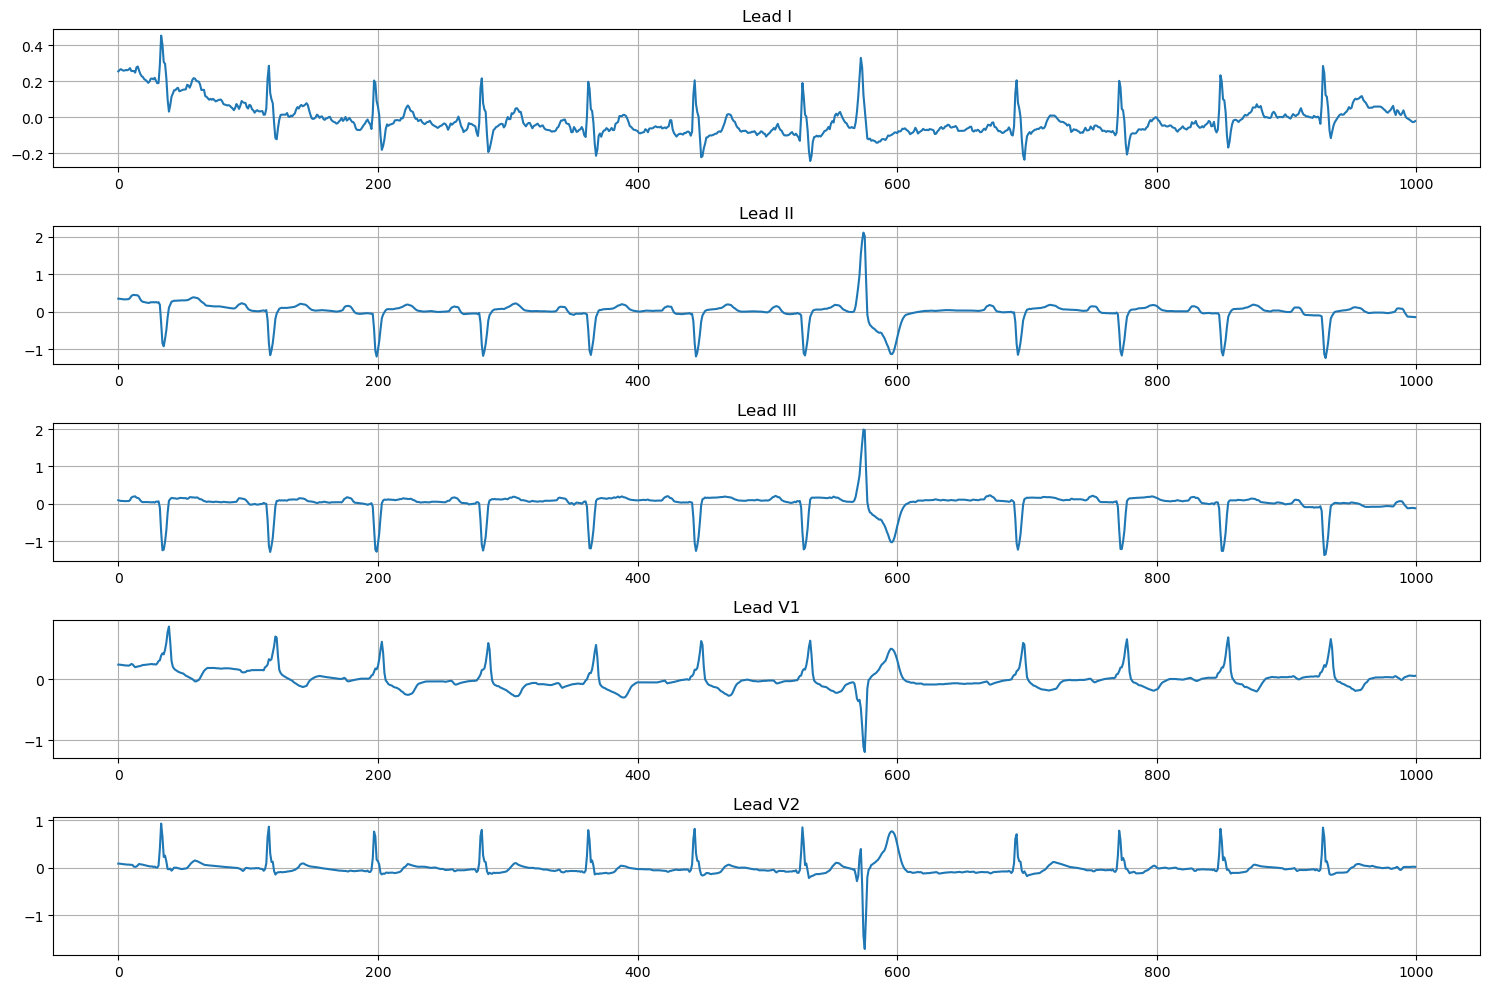

Patient Info - Age: 66.0, Sex: 1
Chagas-related patterns: RBBB, LAFB, AVB, PVC, Q_WAVE, CHAGAS_PATTERN
Original SCP codes: {'IMI': 100.0, 'CRBBB': 100.0, 'LAFB': 100.0, '1AVB': 100.0, 'PVC': 100.0, 'ABQRS': 0.0, 'SR': 0.0}


In [43]:
# Function to visualize ECGs
def plot_ecg(ecg_id, leads=None):
    if leads is None:
        leads = list(range(12))  # All 12 leads
    
    # Find the index of the ECG in our dataset
    idx = Y.index.get_loc(ecg_id) if ecg_id in Y.index else None
    
    if idx is None:
        print(f"ECG ID {ecg_id} not found in dataset")
        return
    
    ecg_data = X[idx]
    
    # Lead names
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    # Plot selected leads
    n_leads = len(leads)
    fig, axes = plt.subplots(n_leads, 1, figsize=(15, n_leads*2))
    
    if n_leads == 1:
        axes = [axes]
    
    for i, lead_idx in enumerate(leads):
        if lead_idx < ecg_data.shape[1]:
            axes[i].plot(ecg_data[:, lead_idx])
            axes[i].set_title(f'Lead {lead_names[lead_idx]}')
            axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print patient info and diagnoses
    print(f"Patient Info - Age: {Y.loc[ecg_id].age}, Sex: {Y.loc[ecg_id].sex}")
    print(f"Chagas-related patterns: {', '.join([col for col in chagas_labels.columns if chagas_labels.loc[ecg_id, col] == 1])}")
    print(f"Original SCP codes: {Y.loc[ecg_id].scp_codes}")

# Function to visualize model activations
def visualize_model_activations(model, ecg_id, layer_idx=-4):
    # Find the index of the ECG in our dataset
    idx = Y.index.get_loc(ecg_id) if ecg_id in Y.index else None
    
    if idx is None:
        print(f"ECG ID {ecg_id} not found in dataset")
        return
    
    # Get the ECG data and preprocess it
    ecg_data = X[idx:idx+1]
    
    # Create a new model that outputs the activations of the specified layer
    activation_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[layer_idx].output
    )
    
    # Get activations
    activations = activation_model.predict(ecg_data)
    
    # Plot activations
    plt.figure(figsize=(15, 10))
    plt.imshow(activations[0].T, aspect='auto', cmap='viridis')
    plt.colorbar(label='Activation')
    plt.title(f'Layer {layer_idx} Activations for ECG ID {ecg_id}')
    plt.xlabel('Time')
    plt.ylabel('Feature Map')
    plt.show()

# To visualize a specific ECG:
plot_ecg(potential_chagas_cases[0], leads=[0, 1, 2, 6, 7])  # Leads I, II, III, V1, V2 are often diagnostic



### RESNET Model

Epoch 1/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 190s 429ms/step - accuracy: 0.9746 - auc_7: 0.7697 - loss: 0.1057 - precision_3: 0.2428 - recall_3: 0.1892 - val_accuracy: 0.9886 - val_auc_7: 0.9678 - val_loss: 0.0346 - val_precision_3: 0.6538 - val_recall_3: 0.2931
Epoch 2/5


c:\Users\rjhha\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_7,loss,precision_3,recall_3,val_accuracy,val_auc_7,val_loss,val_precision_3,val_recall_3
  current = self.get_monitor_value(logs)
c:\Users\rjhha\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


410/410 ━━━━━━━━━━━━━━━━━━━━ 166s 404ms/step - accuracy: 0.9887 - auc_7: 0.9653 - loss: 0.0331 - precision_3: 0.5808 - recall_3: 0.3274 - val_accuracy: 0.9915 - val_auc_7: 0.9077 - val_loss: 0.0326 - val_precision_3: 0.7692 - val_recall_3: 0.5172
Epoch 3/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 170s 414ms/step - accuracy: 0.9882 - auc_7: 0.9339 - loss: 0.0366 - precision_3: 0.6567 - recall_3: 0.4144 - val_accuracy: 0.9908 - val_auc_7: 0.9732 - val_loss: 0.0264 - val_precision_3: 0.6667 - val_recall_3: 0.6207
Epoch 4/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 150s 365ms/step - accuracy: 0.9898 - auc_7: 0.9874 - loss: 0.0260 - precision_3: 0.7139 - recall_3: 0.4651 - val_accuracy: 0.9908 - val_auc_7: 0.9762 - val_loss: 0.0255 - val_precision_3: 0.6324 - val_recall_3: 0.7414
Epoch 5/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 143s 348ms/step - accuracy: 0.9914 - auc_7: 0.9461 - loss: 0.0259 - precision_3: 0.7063 - recall_3: 0.6191 - val_accuracy: 0.9918 - val_auc_7: 0.9592 - val_loss: 0.0251 - val_precision_3: 0.7750 - val

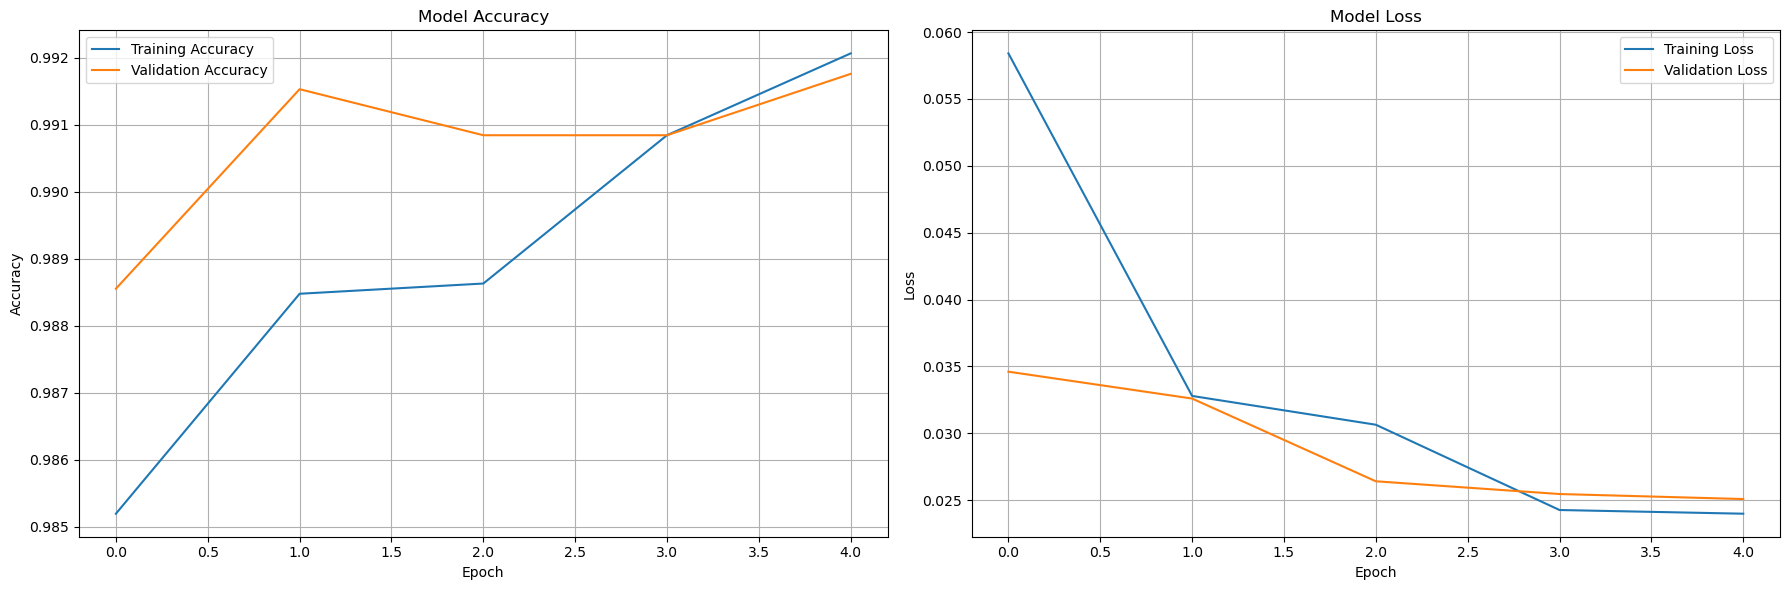

137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step


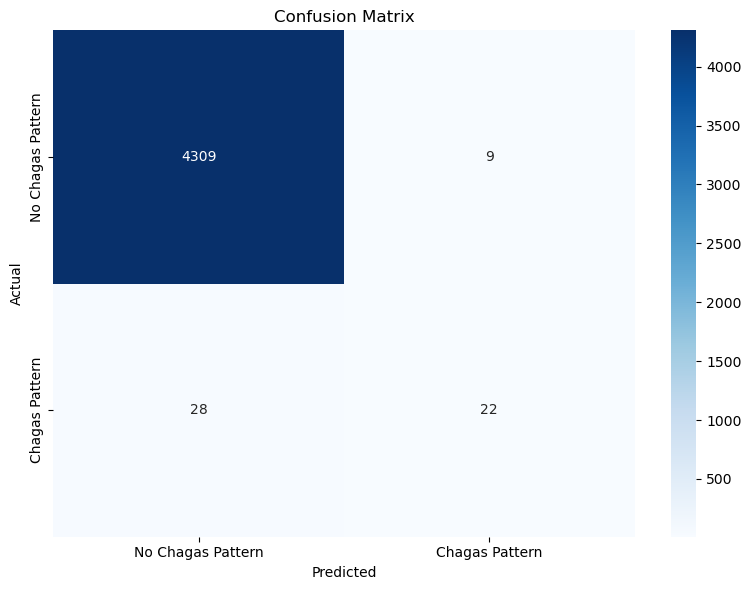

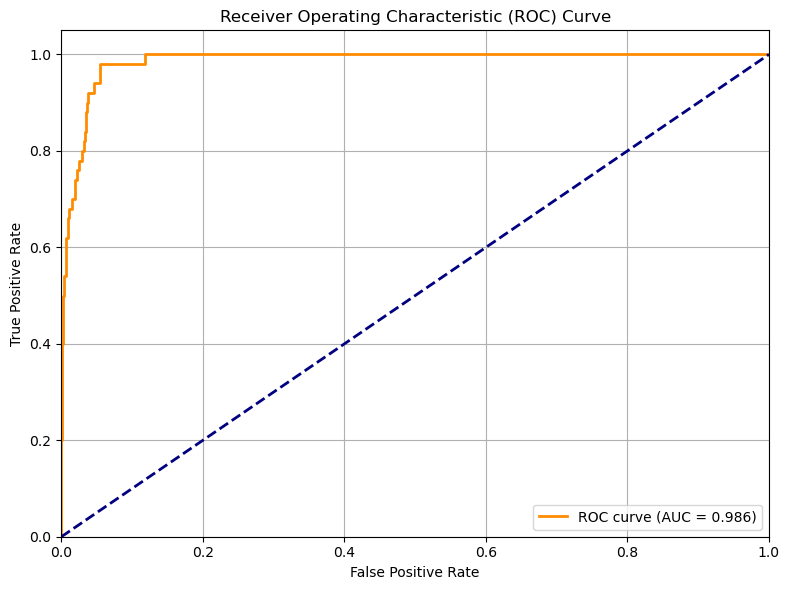


Classification Report:
                   precision    recall  f1-score   support

No Chagas Pattern       0.99      1.00      1.00      4318
   Chagas Pattern       0.71      0.44      0.54        50

         accuracy                           0.99      4368
        macro avg       0.85      0.72      0.77      4368
     weighted avg       0.99      0.99      0.99      4368



(<Functional name=functional_9, built=True>,
 array([9.4336219e-04, 2.7427595e-07, 2.6762566e-05, ..., 2.6278380e-08,
        5.7237493e-03, 5.2320323e-05], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0]))

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Define a residual block for our ResNet architecture
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x
    
    if conv_shortcut:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # First convolution layer
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution layer
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add the shortcut (identity) connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

# Build a ResNet model for ECG classification
def build_resnet_model(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    
    # Initial convolution
    x = Conv1D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual blocks
    # First stack - 64 filters
    x = residual_block(x, 64, conv_shortcut=True)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Second stack - 128 filters
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    # Third stack - 256 filters
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    
    if num_classes == 1:
        outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    else:
        outputs = Dense(num_classes, activation='softmax')(x)  # Multi-class
    
    model = Model(inputs, outputs)
    
    # Compile model
    if num_classes == 1:
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
    else:
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    
    return model

# Get data shape for the model
def get_sample_shape(X_train):
    """Return the shape of a single sample for model input"""
    return X_train.shape[1:]

# Train the ResNet model with callbacks
def train_resnet_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    input_shape = get_sample_shape(X_train)
    model = build_resnet_model(input_shape)
    
    # Define callbacks for early stopping and model checkpointing
    callbacks = [
        EarlyStopping(
            monitor='val_auc',
            patience=10,
            mode='max',
            restore_best_weights=True
        ),
        ModelCheckpoint(
            'chagas_resnet_model.h5',
            monitor='val_auc',
            save_best_only=True,
            mode='max'
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    
    return model, history

# Visualize model training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot AUC if available
    if 'auc' in history.history:
        plt.figure(figsize=(9, 6))
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Evaluate model performance
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred_prob = model.predict(X_test)
    
    # Ensure y_pred_prob is the right shape (it might be a 2D array with shape [n_samples, 1])
    if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] == 1:
        y_pred_prob = y_pred_prob.flatten()
        
    # Convert to binary predictions
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    
    # Create confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['No Chagas Pattern', 'Chagas Pattern'],
        yticklabels=['No Chagas Pattern', 'Chagas Pattern']
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Chagas Pattern', 'Chagas Pattern']))
    
    return y_pred_prob, y_pred



# Execute the full pipeline
def run_chagas_detection_pipeline(X_train, y_train, X_val, y_val, X_test, y_test, epochs=5, batch_size=32):
    # Train model
    model, history = train_resnet_model(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    
    # Visualize training history
    plot_training_history(history)
    
    # Evaluate model
    y_pred_prob, y_pred = evaluate_model(model, X_test, y_test)
    
    
    
    return model, history, y_pred_prob, y_pred


run_chagas_detection_pipeline(X_train, y_train, X_val, y_val, X_test, y_test, epochs=5, batch_size=32)